In [1]:
# 数据路径
DATA_PATH = './mnist/'
# 如果数据集不存在是否下载数据集
DOWNLOAD_DATASET = True
# 批量大小
BATCH_SIZE = 50
# 设置，如果GPU可用，是否使用GPU
USEGPU = True

In [2]:
# 用于读取表格数据
import pandas as pd
# 用于构建神经网络和相应数据处理
import torch
import torch.utils.data
import torch.nn as nn
import torchvision
# 用于图像的读取和基本处理
import cv2 as cv
# 用于支持其他模块以及非torch的矩阵操作
import numpy as np
# 用于显示图像
import matplotlib.pyplot as plt
# 用于计算训练用时
import datetime
# 用于XML文件读写
import xml.etree.ElementTree as ElementTree

In [3]:
# 确定正在使用的运算设备
if USEGPU:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
else:
    device = 'cpu'

print('using',device)

using cpu


In [4]:
# 如果没有记录的平均值和标准差
# 就计算训练集的平均值和标准差并保存
# 如果已经存在
# 则读取均值和方差
# 初始化平均值和标准差的存储变量
datasetMean = 0
datasetStd = 0
# 初始化文件路径
xmlFilePath = DATA_PATH+'TrainsetMeanAndStd.xml'
# 尝试读取数据
try:
    tree = ElementTree.parse(xmlFilePath)
    rootNode = tree.getroot()
    for node in rootNode:
        if node.tag == 'mean':
            datasetMean = float(node.attrib['value'])
        elif node.tag =='std':
            datasetStd = float(node.attrib['value'])
except:
    # 如果读取失败则重新计算均值和方差
    # 计算均值和方差之前先要保证训练集存在
    train_data = torchvision.datasets.MNIST(root=DATA_PATH, train=True,download=DOWNLOAD_DATASET, 
                                        transform=torchvision.transforms.ToTensor())
    print('计算训练集数据均值和方差中')
    # 计算平均值
    tempSum = 0
    for i, data in enumerate(train_data):
        img, label = data
        tempSum = tempSum + float(img.mean())
    datasetMean = tempSum/len(train_data)
    # 计算标准差
    tempSum = 0
    for i, data in enumerate(train_data):
        img, label = data
        tempSum = tempSum + float(((img-datasetMean)**2).mean())
    datasetStd = (tempSum/len(train_data))**0.5
    print('计算完毕')
    # 生成XML并保存
    rootNode = ElementTree.Element('root')
    meanNode = ElementTree.SubElement(rootNode,'mean')
    meanNode.attrib = {'value':str(datasetMean)}
    stdNode = ElementTree.SubElement(rootNode,'std')
    stdNode.attrib = {'value':str(datasetStd)}
    tree = ElementTree.ElementTree(rootNode)
    # 生成的XML保存于DATA_PATH路径之下
    tree.write(xmlFilePath)
print('mean',datasetMean)
print('std',datasetStd)


mean 0.13066047927398855
std 0.30810785931704165


In [5]:
# MNIST数据集载入
# 图像数据的归一化和正则化
# 需要注意的是ToTensor转化器在加载数据的时候已经把图像像素值从[0,255]变成了[0.0,1.0]
# 载入MNIST数据集
# ToTensor可以把像素数据整理到[0.0,1.0]区间。

# 构造转换器
TF = torchvision.transforms
transformFunction = TF.Compose([TF.ToTensor(),
                                TF.Normalize(mean=(datasetMean,),std=(datasetStd,))
                               ])
#transformFunction = TF.Compose([TF.ToTensor(),])
# 载入训练集和测试集
train_data = torchvision.datasets.MNIST(root=DATA_PATH, train=True,download=DOWNLOAD_DATASET, 
                                        transform=transformFunction)
test_data = torchvision.datasets.MNIST(root=DATA_PATH, train=False,download=DOWNLOAD_DATASET, 
                                        transform=transformFunction)
# 用DataLoader把数据集打包起来
Data = torch.utils.data
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = Data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)


In [6]:
# 定义网络
import torch.nn as nn
import torch.nn.functional as F
class ClassificationMNIST(nn.Module):
    def __init__(self):
        super(ClassificationMNIST,self).__init__()
        self.n1=nn.Sequential(nn.Conv2d(1, 4, 3, 1),nn.ReLU(), nn.MaxPool2d(kernel_size=2))
        self.n2=nn.Sequential(nn.Conv2d(4, 8, 3, 1),nn.ReLU(), nn.MaxPool2d(kernel_size=2))
        #self.n3=nn.Sequential(nn.Conv2d(8, 16, 3, 1),nn.ReLU(), nn.MaxPool2d(kernel_size=2))
        self.fc1 = nn.Linear(8*5*5,10)
        #self.fc2 = nn.Linear(33,15)
        
    def forward(self, x):
        x = self.n1(x)
        x = self.n2(x)
        #x = self.n3(x)
        x = x.view(-1,8*5*5)
        x = self.fc1(x)
       #x = self.fc2(x)
        #output = (torch.sigmoid(x)).round()
        output = torch.sigmoid(x)
        return output

In [7]:
# 初始化网络，及相关函数
cnn=ClassificationMNIST().to(device)
EPOCH = 5
#LR = 0.001
#LR = 0.0001
# 学习率是个超参数，这东西是实验出来的
LR = 0.001

# 定义损失函数和优化器
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)
loss_func = torch.nn.CrossEntropyLoss(size_average=False)

/home/taixuan/miniconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [8]:
# 进行训练
if str(device) == 'cpu':
    pass
else:
    torch.cuda.synchronize()
starttime=datetime.datetime.now()
# 训练
for epoch in range(EPOCH):
    for i,data in enumerate(train_loader):
        # 获取数据并把训练用数据转移到GPU上
        b_x,b_y = data
        b_x = b_x.to(device)
        b_y = b_y.to(device)
        # 前馈和计算损失
        output = cnn(b_x)
        loss = loss_func(output, b_y)
        # 反馈
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i% 500 == 0:
            for j,testdata in enumerate(test_loader):
                tx,ty =testdata
                tx = tx.to(device)
                ty = ty.to(device)
                test_output = cnn(tx)
                # !!!!!!!! Change in here !!!!!!!!! #
                pred_y = torch.max(test_output, 1)[1].data.squeeze()  # move the computation in GPU
                accuracy = torch.sum(pred_y == ty).type(torch.FloatTensor) / ty.size(0)
                print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.cpu().numpy(), '| test accuracy: %.2f' % accuracy)
                break
                pass # 防止提示语法错误写了个pass。其实没有什么语法错误。可能是语法检查器的问题。
                
if str(device) == 'cpu':
    pass
else:
    torch.cuda.synchronize()
endtime=datetime.datetime.now()
print('Train time:',(endtime-starttime).seconds,'seconds')

Epoch:  0 | train loss: 115.3246 | test accuracy: 0.14
Epoch:  0 | train loss: 78.7954 | test accuracy: 0.88
Epoch:  0 | train loss: 77.2586 | test accuracy: 0.86
Epoch:  1 | train loss: 76.2631 | test accuracy: 0.96
Epoch:  1 | train loss: 74.5290 | test accuracy: 0.96
Epoch:  1 | train loss: 74.7486 | test accuracy: 1.00
Epoch:  2 | train loss: 74.8678 | test accuracy: 0.98
Epoch:  2 | train loss: 75.9279 | test accuracy: 0.98
Epoch:  2 | train loss: 74.9025 | test accuracy: 0.92
Epoch:  3 | train loss: 74.2379 | test accuracy: 0.96
Epoch:  3 | train loss: 74.7821 | test accuracy: 0.94
Epoch:  3 | train loss: 74.7280 | test accuracy: 0.92
Epoch:  4 | train loss: 75.2819 | test accuracy: 0.96
Epoch:  4 | train loss: 75.0696 | test accuracy: 0.98
Epoch:  4 | train loss: 73.8026 | test accuracy: 0.94
Train time: 69 seconds


In [9]:
# 查看全部测试集
testLen=len(test_data)
tempSum=0
for i,testdata in enumerate(test_loader):
    img,label =testdata
    img,label = img.to(device), label.to(device)
    output = cnn(img)
    pre = torch.max(output, 1)[1].data.squeeze()
    #print('pre',pre)
    #print('label',label)
    tempSum = tempSum+(pre==label).sum()
print(float(tempSum.data)/testLen)


0.9741


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cnn answers:
[1 6 7 7 7 8 8 0 6 0 3 4 2 1 8 3 6 1 6 0 8 0 9 7 1 7 2 8 7 9 8 9 9 5 1 1 3
 9 1 5 8 7 0 3 2 7 2 4 8 9]
labels:
[1 6 7 7 7 8 8 0 6 0 3 4 2 1 8 3 6 1 6 0 8 0 9 7 1 7 2 8 7 9 8 9 9 5 1 1 3
 9 1 5 8 7 0 3 2 7 2 4 8 9]


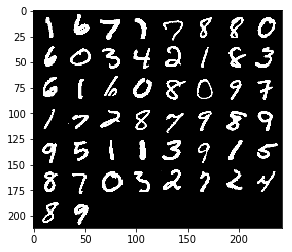

In [10]:
import torchvision
import matplotlib.pyplot as plt
# 在训练集上
for i,data in enumerate(train_loader):
    img, label =data
    tempimg = torchvision.utils.make_grid(img)
    plt.imshow(np.transpose(tempimg.numpy(),(1, 2, 0)))
    #print(img.size())
    output = cnn(img)
    pre = torch.max(output, 1)[1].data.squeeze()
    print('cnn answers:')
    print(pre.numpy())
    print('labels:')
    print(label.numpy())
    break


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cnn answers:
[2 2 5 0 4 7 2 9 5 5 8 6 7 6 8 1 3 3 4 4 6 8 3 2 9 1 9 1 9 1 9 1 3 3 9 0 7
 9 2 1 1 2 4 9 0 9 2 5 0 5]
labels:
[2 2 5 0 4 7 2 9 5 5 8 6 7 6 8 1 3 9 4 4 6 8 3 2 9 1 9 1 9 1 9 1 3 3 9 0 7
 9 2 1 1 2 4 9 0 9 2 5 0 5]


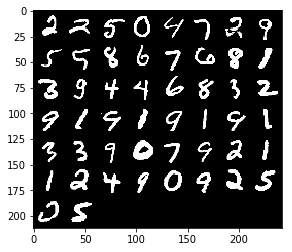

In [11]:
# 在测试集上
for i,data in enumerate(test_loader):
    img, label =data
    tempimg = torchvision.utils.make_grid(img)
    plt.imshow(np.transpose(tempimg.numpy(),(1, 2, 0)))
    #print(img.size())
    output = cnn(img)
    pre = torch.max(output, 1)[1].data.squeeze()
    print('cnn answers:')
    print(pre.numpy())
    print('labels:')
    print(label.numpy())
    break

In [14]:
x = torch.rand(10)

In [15]:
   # 计算测试集准确率
    totalRightNumber = 0
    batchSize = 3
    labelNumber = 15
    for i,data in enumerate(testLoader):
        b_x,b_y = data
        b_x = b_x.to(device)
        b_y = b_y.to(device)
        output = F.sigmoid(cnn(b_x))
        # 计算正确标签数
        totalRightNumber = (abs(output-b_y)<0.5).sum()+totalRightNumber
        #print('aaa',(abs(output-b_y)<0.5).sum())
        ##print('aaa',output,b_y)
        ##### 这里需要用最大值的索引作为分类号
        #output2 = torch.max(output,1)[1]
        #totalRightNumber = totalRightNumber + (output2 == b_y).sum()
        #print('output',output)
        #print('b_y',b_y)
    #else:
        #print(loss = loss_func(F.sigmoid(output), b_y))
    # 输出正确率
    #print('rate on test set:',totalRightNumber/(len(testset)*batchSize*labelNumber))
    print('maintotal',totalRightNumber)
    print('rate on test set:',float(totalRightNumber[0])/(len(testLoader)*batchSize*labelNumber))
    #if epoch % 20 == 0:
    #    test_output = cnn(test_x)
    #    def functemp(x):
    #        if(x[0]> 0.5):
    #            return 0
    #        else:
    #            return 1
    #    test_output=list(map(functemp,list(test_output)))
    #    print(torch.Tensor(test_output))
    #    print(test_y)
        

IndentationError: unexpected indent (<ipython-input-15-f2fe26a90d4c>, line 2)

In [ ]:
x.round()

In [ ]:
mt = ElementTree.ElementTree()
mt.getroot()=t

In [ ]:
for i in tree.getroot():
    print(i)

In [ ]:
rootNode = ElementTree.Element('root')
meanNode = ElementTree.SubElement(rootNode,'mean')
meanNode.attrib = {'value':124}
stdNode = ElementTree.SubElement(rootNode,'std')
stdNode.attrib = {'value':423412}
tree = ElementTree.ElementTree(rootNode)


In [39]:
# 以下几个方框里是神经网络可视化的尝试
L = []
for m in cnn.modules():
    if isinstance(m, nn.Conv2d):
       # print(m.weights.data)
        L.append(m.weight.data)

In [37]:
for i in L:
    print(i.size())

torch.Size([4, 1, 3, 3])
torch.Size([8, 4, 3, 3])


In [49]:
ToPIL = torchvision.transforms.ToPILImage()
#L1 = map(lambda x:ToPIL(x.reshape((1,2))),L)
#for i in L[0]:
#    print(ToPIL(i).show())
ToPIL(torchvision.utils.make_grid(L[0])).show()
ToPIL(torchvision.utils.make_grid(L[1][:,1,:,:])).show()

In [ ]:
# 图像和标签查看工具
ToPIL = torchvision.transforms.ToPILImage()
x=0
y =0
for i,data in enumerate(test_loader):
    img,label = data
    x = ToPIL(img[0])
    y=label
    break
print(y)
x

In [ ]:
# 不要有事没事加sigmoid之类的函数，有可能导致输出变得相同